# Overview of the mainscripts to run the free energy exploration
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
1.	raw_to_PR: 	Timeseries -> PR_timeseries (Is on harddrive)
2.	Data_to_CC: 	Timeseries + PR_timeseries -? pruned_clique_complex + entropies/mutinfo/F’s
3.	CC_to_F: 	Pruned_clique_complex + L_p -> Knill’s F (for this L_p needs to be generated before the function/loop. Matrix decompression needs to be used to select which L_p columns/rows)
4.	CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P
5.	CC_to_minF_custom:	Pruned_clique_complex -> Knill’s min F from custom P

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import math
from scipy.optimize import minimize

C:\Users\cyril\AppData\Local\Temp\ipykernel_22144\2221825761.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**1 raw_to_PR: 	Timeseries -> PR_timeseries**

Define functions for phase randomisation

In [163]:
def phase_randomization(time_series):
    # Compute the Fourier transform of the time series
    fourier_transform = np.fft.fft(time_series)

    # Get the phases of the Fourier transform
    phases = np.angle(fourier_transform)

    # Shuffle the phases randomly
    np.random.shuffle(phases)

    # Apply the shuffled phases to the Fourier transform
    randomized_fourier_transform = np.abs(fourier_transform) * np.exp(1j * phases)

    # Reconstruct the randomized time series
    randomized_time_series = np.fft.ifft(randomized_fourier_transform)

    # Return the randomized time series
    return randomized_time_series.real

def phase_randomization_dataframe_fixed(df):
    df_dropped = df#.drop(df.columns[-1], axis=1)  # Drop the last column from the dataframe

    ##randomized_df = pd.DataFrame()  # Create an empty dataframe to store the randomized data
    L=[]
    for _, row in df_dropped.iterrows():
        randomized_row = phase_randomization(row.values)
        L.append(randomized_row)# Apply phase randomization to each row
        #randomized_df = randomized_df.concat(pd.Series(randomized_row), ignore_index=True)  # Add randomized row to the dataframe
    #randomized_df.columns = df_dropped.columns  # Assign the column names to the randomized dataframe
    #randomized_df=pd.concat(L)
    return pd.DataFrame(L)#randomized_df

From the data folder, import and store the real time series and create and store the PR time series. **NOTE: until now only for the first 10 subjects**

In [5]:
# Path for REST1 real time series
path = glob.glob("C:\\Users\\cyril\\Documents\\MSc Physics and Astronomy\\Thesis\\GitHub\\Young_Adults_time_series\\*REST1*.txt")

for filename in path[:10]:
    # Import and save real time series
    df=pd.read_csv(filename,sep='\t',header=None)
    df.to_csv('TimeSeries_REAL/REST1/REAL_'+filename[-103:], sep='\t', index=False, header=False)

    # Create and save PR time series
    df = phase_randomization_dataframe_fixed(df)
    df.to_csv('TimeSeries_PR/REST1/PR_'+filename[-103:], sep='\t', index=False, header=False)

Plot to see the distribution of timeseries values of Real vs Phase Randomised. **NOTE: this is just to check the phase randmisation. No pruning is done here.**

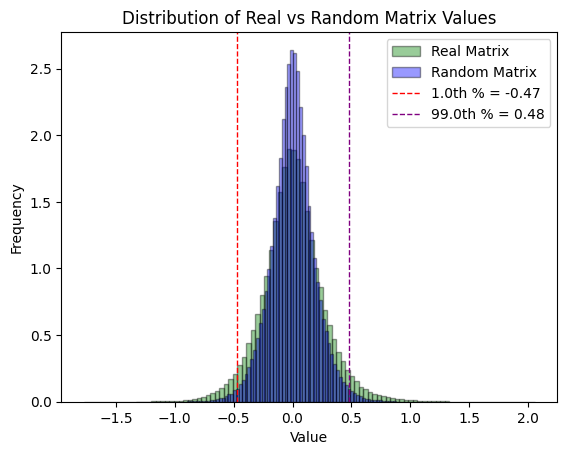

In [9]:
# Import the stored PR and real time series to compare their distribution
timeseries_REAL=pd.read_csv('TimeSeries_REAL\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)
timeseries_PR=pd.read_csv('TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt',sep='\t',header=None)

# Flatten the matrices
real_corr_flat = np.array(timeseries_REAL).flatten()
random_corr_flat = np.array(timeseries_PR).flatten()

# Plot the distribution of correlation values for real vs random data
plt.hist(real_corr_flat, density=True, bins=100, label='Real Matrix', alpha=0.4, color='green', edgecolor='black')
plt.hist(random_corr_flat, density=True, bins=100, label='Random Matrix', alpha=0.4, color='blue', edgecolor='black')

# Calculate percentiles
q010 = np.quantile(random_corr_flat, 0.010)
q990 = np.quantile(random_corr_flat, 0.990)

# Draw red dotted lines at the 1.0th and 99.0th percentiles
plt.axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
plt.axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

# Add legend to the plot
plt.legend()

# Optional: Add titles and labels
plt.title('Distribution of Real vs Random Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

**2.	Data_to_CC: 	Timeseries + PR_timeseries -> pruned_clique_complex + entropies/mutinfo/F’s**

Define function to obtain complete clique complex of all mutual informations and function to split this into the mutual informations per dimension

In [164]:
def obtain_mutual_information(filename, max_d, number_of_variables): 

    # Import time series data
    df = pd.read_csv(filename, sep='\t', header=None)

    # Mask using the 99th and 1th percentile
    stacked_series = df.stack()
    quantile_99 = stacked_series.quantile(0.99)
    quantile_01 = stacked_series.quantile(0.01)
    df[df > quantile_99] = quantile_99
    df[df < quantile_01] = quantile_01

    # Initialize an empty DataFrame to hold discretized values
    discretized_time_series = pd.DataFrame()
    max_BOLD = df.max().max()
    min_BOLD = df.min().min()
    desired_number_of_bins = 16
    stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
    bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

    # Iterate over each column of 'df'
    for col in df.columns:
        data = df[col].tolist()
        bin_numbers = np.digitize(data, bin_edges)
        
        # Create a DataFrame with the current column's discretized values
        col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
        
        # Concatenate the new DataFrame along the columns axis
        discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

    # Import the information topology functions needed
    %run infotopo.py
    
    # Settings to use infotopo functions
    dataset = np.array(discretized_time_series).T
    work_on_transpose = False 
    nb_of_values = 16
    deformed_probability_mode = False
    supervised_mode = False
    forward_computation_mode = True
    sampling_mode = 1

    # Call infotopo functions for entropy, mutual information and free energy
    information_topo = infotopo(dimension_max = max_d, 
                                dimension_tot = number_of_variables, 
                                sample_size = 2400, 
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values, 
                                sampling_mode = sampling_mode, 
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode, 
                                forward_computation_mode = forward_computation_mode)

    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) 
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)

    return Nentropie, Ninfomut, Nfree_energy

def infomut_per_dimension(data):

    list_1 = []  # For keys of length 1
    list_2 = []  # For keys of length 2
    list_3 = []  # For keys of length 3
    list_4 = []  # For keys of length 4

    for key, value in data.items():
        if len(key) == 1:
            list_1.append(value)
        elif len(key) == 2:
            list_2.append(value)
        elif len(key) == 3:
            list_3.append(value)
        elif len(key) == 4:
            list_4.append(value)

    return list_1, list_2, list_3, list_4

Obtain all mutual informations for the total clique complex from Real and Randomised data

In [133]:
# Run for max_d=3 and nb_variables=60 takes about 4min
Real_Nentropie, Real_Ninfomut, Real_Nfree_energy = obtain_mutual_information('Cyril\TimeSeries\REST1\REAL_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', 3, 10)
Random_Nentropie, Random_Ninfomut, Random_Nfree_energy = obtain_mutual_information('Cyril\TimeSeries_PR\REST1\PR_100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', 3, 10)

Split the obtained mutual informations into each dimension to visualise the cutoff for each dimension

In [111]:
# Split the mutual informations per dimension
Real_I1, Real_I2, Real_I3, Real_I4 = infomut_per_dimension(Real_Ninfomut)
Random_I1, Random_I2, Random_I3, Random_I4 = infomut_per_dimension(Random_Ninfomut)

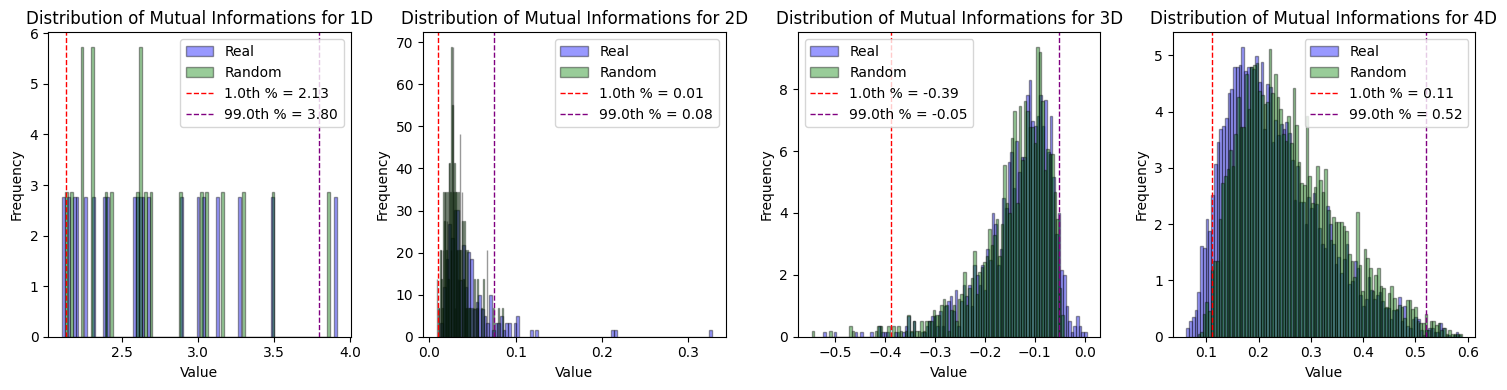

In [107]:
# Define the data
Real = [Real_I1, Real_I2, Real_I3, Real_I4]
Random = [Random_I1, Random_I2, Random_I3, Random_I4]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Iterate over each set of data and plot
for i in range(4):
    Real_values = Real[i]
    Random_values = Random[i]
    
    # Plot the distribution of correlation values for real vs random data
    axes[i].hist(Real_values, bins=100, density=True, label='Real', alpha=0.4, color='blue', edgecolor='black')
    axes[i].hist(Random_values, bins=100, density=True, label='Random', alpha=0.4, color='green', edgecolor='black')

    # Calculate percentiles
    q010 = np.quantile(Random_values, 0.010)
    q990 = np.quantile(Random_values, 0.990)

    # Draw red dotted lines at the 1.0th and 99.0th percentiles
    axes[i].axvline(q010, color='red', linestyle='--', linewidth=1, label=f'1.0th % = {q010:.2f}')
    axes[i].axvline(q990, color='purple', linestyle='--', linewidth=1, label=f'99.0th % = {q990:.2f}')

    # Add legend to the plot
    axes[i].legend()

    # Optional: Add titles and labels
    axes[i].set_title(f'Distribution of Mutual Informations for {i+1}D')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


In [165]:
# Function to filter keys based on length A
def filter_keys_by_length(dictionary, length):
    return {key: value for key, value in dictionary.items() if isinstance(key, tuple) and len(key) == length}

In [134]:
print(len(Real_Ninfomut))
print(len(Random_Ninfomut))

# Define common quantiles
quantile_min = 0.010
quantile_max = 0.990

# Initialize a dictionary to store filtered data for different key lengths
filtered_data = {}
print('There is no cutoff for 1D since all vertices should be included')

# Loop through the data
for key_length in range(2, 4):
    # Use the mutinfo's per dimension
    data = filter_keys_by_length(Real_Ninfomut, key_length)
    print(len(data))

    # Calculate quantiles based on the key length
    I_min = np.quantile(locals()[f"Random_I{key_length}"], quantile_min)
    I_max = np.quantile(locals()[f"Random_I{key_length}"], quantile_max)
    print(f'So the cutoff for {key_length}D is between {I_min} and {I_max}')
    
    # Filter data
    mask = {key: not(I_min <= value <= I_max) for key, value in data.items()}
    filtered_data[key_length] = {key: value for key, value in data.items() if mask[key]}

# Print filtered dictionaries
print("Filtered Clique Complexes per dimension:")
for key_length, filtered_dict in filtered_data.items():
    print(f'For {key_length}D with length {len(filtered_dict)}/{len(Real[key_length-1])}: {filtered_dict}')

# Combine filtered dictionaries into one pruned_clique_complex dictionary
pruned_clique_complex = filter_keys_by_length(Real_Ninfomut, 1)
pruned_clique_complex_MD = {key: value for filtered_dict in filtered_data.values() for key, value in filtered_dict.items()}
pruned_clique_complex.update(pruned_clique_complex_MD)
print("Total Pruned Clique Complex length:", len(pruned_clique_complex))

175
175
There is no cutoff for 1D since all vertices should be included
45
So the cutoff for 2D is between 0.010926261767654743 and 0.04083147302478715
120
So the cutoff for 3D is between -0.1524613885090426 and -0.05240367154505402
Filtered Clique Complexes per dimension:
For 2D with length 10/190: {(1, 9): 0.11753803484330305, (2, 10): 0.05743714442760517, (4, 5): 0.04398813059588047, (4, 7): 0.09121609630730454, (4, 8): 0.10243791283927717, (5, 6): 0.04384438076249797, (5, 7): 0.059733599112384184, (5, 8): 0.07830323432472941, (5, 10): 0.04168357025097169, (7, 8): 0.09758570865305405}
For 3D with length 11/1140: {(1, 2, 9): -0.05091767317230733, (1, 3, 4): -0.050501801203796326, (1, 3, 9): -0.04875928768348636, (1, 4, 9): -0.04814369548150754, (1, 9, 10): -0.047918406879204234, (2, 5, 6): -0.15378962534269913, (3, 4, 7): -0.03954897251326628, (3, 4, 8): -0.04715920295107523, (4, 7, 8): -0.029439173820963838, (4, 7, 9): -0.04269643502056386, (5, 6, 10): -0.15456587269597932}
Total Pr

Compute the average free energy component, i.e. mutual information, as according to Pierre Baudot. In green also included the Free energy from Pierre.

In [99]:
#average_free_energy = sum(Nfree_energy.values())/len(Nfree_energy.values())
#print(f'The average free energy of this subject is {average_free_energy}')

average_free_energy_component = sum(pruned_clique_complex.values())/len(pruned_clique_complex.values())
print(f'The free energy component (average mutual information) of this subject is {average_free_energy_component}')

The free energy component (average mutual information) of this subject is 0.23493333663594038


Output a pruned clique complex containing only simplices as desired for Knill's approach

In [100]:
print(len(pruned_clique_complex))
clique_complex = [frozenset(key) for key in pruned_clique_complex if key in pruned_clique_complex]
print(len(clique_complex))

384
384


In [101]:
print(len(Real_I1))
print(len(Real_I2))
print(len(Real_I3))
print(len(Real_I4))

20
190
1140
4845


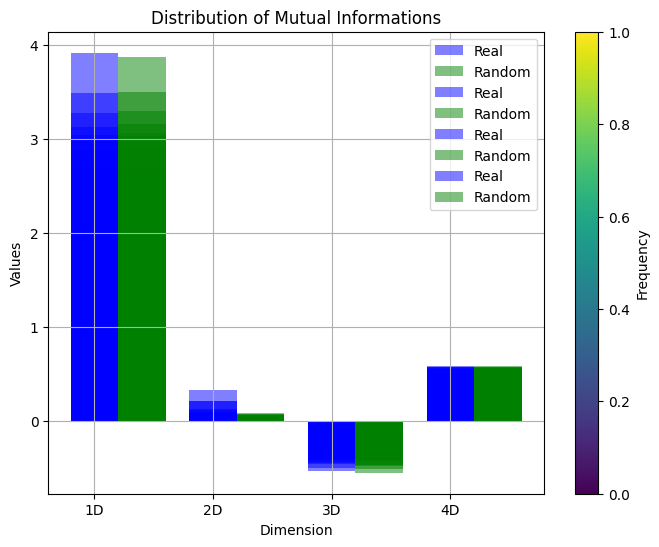

In [102]:
# Define the data
Real = [Real_I1, Real_I2, Real_I3, Real_I4]
Random = [Random_I1, Random_I2, Random_I3, Random_I4]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set up the color map
cmap = plt.cm.viridis

# Plot the histograms
for i in range(len(Real)):
    x = [i] * len(Real[i])
    ax.bar(x, Real[i], color='blue', alpha=0.5, width=0.4, label='Real')
    ax.bar([pos + 0.4 for pos in x], Random[i], color='green', alpha=0.5, width=0.4, label='Random')

# Set x-axis ticks and labels
ax.set_xticks(range(len(Real)))
ax.set_xticklabels(['1D', '2D', '3D', '4D'])

# Add labels and title
ax.set_xlabel('Dimension')
ax.set_ylabel('Values')
ax.set_title('Distribution of Mutual Informations')

# Add legend
ax.legend()

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Frequency')

# Show the plot
plt.grid(True)
plt.show()

Summary mainframe for PR+REAL timeseries to Pruned_clique_complex and average free energy component:
- Loop through dataset to obtain and store information functionals (entropy, mut_info, free_energy)
- Loop through mut_info lists to obtain and store pruned_clique_complexes

In [166]:
# Function to obtain pruned_clique_complex for given REAL and PHASE RANDOMISED timeseries
def obtain_pruned_CC(filename_REAL, filename_PR, max_d, number_of_variables):
    # Extract patient ID from filename
    identification_code = filename_REAL[-103:-97]

    # Run for max_d=3 and nb_variables=60 takes about 4min
    Real_Ninfomut = obtain_mutual_information(filename_REAL, max_d, number_of_variables)[1]
    Random_Ninfomut = obtain_mutual_information(filename_PR, max_d, number_of_variables)[1]

    # Given dictionary
    data = Real_Ninfomut

    # Define common quantiles
    quantile_min = 0.010
    quantile_max = 0.990

    # Initialize a dictionary to store filtered data for different key lengths
    filtered_data = {}
    print('There is no cutoff for 1D since all vertices should be included')

    # Loop through the data
    for key_length in range(2, max_d+1):
        # Use the mutinfo's per dimension
        data = filter_keys_by_length(Real_Ninfomut, key_length)
        print(len(data))

        # Calculate quantiles based on the key length
        Mutinfo_iD_list = list(filter_keys_by_length(Random_Ninfomut, key_length).values())
        I_min = np.quantile(Mutinfo_iD_list, quantile_min)
        I_max = np.quantile(Mutinfo_iD_list, quantile_max)
        print(f'So the cutoff for {key_length}D is between {I_min} and {I_max}')
        
        # Filter data
        mask = {key: not(I_min <= value <= I_max) for key, value in data.items()}
        filtered_data[key_length] = {key: value for key, value in data.items() if mask[key]}

    # Print filtered dictionaries
    print("Filtered Clique Complexes per dimension:")
    for key_length, filtered_dict in filtered_data.items():
        print(f'For {key_length}D with length {len(filtered_dict)}/{len(list(filter_keys_by_length(Real_Ninfomut, key_length)))}: {filtered_dict}')

    # Combine filtered dictionaries into one pruned_clique_complex dictionary
    pruned_clique_complex = filter_keys_by_length(Real_Ninfomut, 1)
    pruned_clique_complex_MD = {key: value for filtered_dict in filtered_data.values() for key, value in filtered_dict.items()}
    pruned_clique_complex.update(pruned_clique_complex_MD)

    # Compute the average free energy component (average mutual information)
    average_free_energy_component = sum(pruned_clique_complex.values())/len(pruned_clique_complex.values())

    # Remove mutual informations from pruned clique complex
    clique_complex = [frozenset(key) for key in pruned_clique_complex if key in pruned_clique_complex]

    return [identification_code, average_free_energy_component, len(clique_complex), clique_complex]

In [157]:
# INSERT DESIRED SETTINGS
REST_state = 'REST1' # Choose REST1 or REST2
max_d = 3
number_of_variables = 10

# Path for REST1 real time series
path_REAL = glob.glob(f"TimeSeries_REAL\{REST_state}\*.txt")
path_PR = glob.glob(f"TimeSeries_PR\{REST_state}\*.txt")

# Create an empty dataframe
df_InfoCoho = pd.DataFrame(columns=['identification_code', 'average_free_energy_component', 'len(pruned_CC)', 'pruned_clique_complex'])

# Loop over the datafiles
for i in range(0, 2): #len(path)):
    filename_REAL = path_REAL[i]
    filename_PR = path_PR[i]
    df_InfoCoho.loc[len(df_InfoCoho)] = obtain_pruned_CC(filename_REAL, filename_PR, max_d, number_of_variables)

# Store dataframe containing patient_ID, pruned_clique_complex and the average_free_energy_component
df_InfoCoho.to_csv(f'InfoCoho_{REST_state}.txt', sep='\t', index=False)

There is no cutoff for 1D since all vertices should be included
45
So the cutoff for 2D is between 0.012728516688453375 and 0.039026250750394814
120
So the cutoff for 3D is between -0.15108653621614718 and -0.052627689877681315
Filtered Clique Complexes per dimension:
For 2D with length 12/45: {(1, 9): 0.11753803484330305, (1, 10): 0.04036144115299489, (2, 10): 0.05743714442760517, (4, 5): 0.04398813059588047, (4, 7): 0.09121609630730454, (4, 8): 0.10243791283927717, (5, 6): 0.04384438076249797, (5, 7): 0.059733599112384184, (5, 8): 0.07830323432472941, (5, 10): 0.04168357025097169, (7, 8): 0.09758570865305405, (9, 10): 0.040576536601456326}
For 3D with length 12/120: {(1, 2, 9): -0.05091767317230733, (1, 3, 4): -0.050501801203796326, (1, 3, 9): -0.04875928768348636, (1, 4, 9): -0.04814369548150754, (1, 9, 10): -0.047918406879204234, (2, 5, 6): -0.15378962534269913, (3, 4, 7): -0.03954897251326628, (3, 4, 8): -0.04715920295107523, (4, 7, 8): -0.029439173820963838, (4, 7, 9): -0.0426964

**3. CC_to_F: 	Pruned_clique_complex + L_p -> Knill’s F**

In [167]:
def count_occurrences(dicts):
    occurrences = {}
    # Iterate over all dictionaries
    for d in dicts:
        for key in d:
            occurrences[key] = occurrences.get(key, 0) + 1
    return occurrences

def generate_clique_probabilities(dict_list):  
      
    # Count occurrences
    occurrences = count_occurrences(dict_list)

    # Divide each value by the sum
    normalized_occurrences = {key: value /sum(occurrences.values()) for key, value in occurrences.items()}
    
    dict_values_list = []

    for i in range(0, len(dict_list)):
        # Initialize an empty list to store values
        values_list = []

        # Iterate over keys of dict1
        for key in dict_list[i]:
            # Check if the key exists in normalized_occurrences
            if key in normalized_occurrences:
                # If the key exists, append its corresponding value to the list
                values_list.append(normalized_occurrences[key])

        dict_values_list.append(np.array(values_list))

    return dict_values_list

In [168]:
%run Week_18_functions.py

In [93]:
# Choose desired settings
REST_state = 'REST1'

# Read the CSV file
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')

# Extract the first and second columns as lists
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 1].apply(eval).tolist()

# Generate Free energies
F_list = []
clique_probabilities_list = generate_clique_probabilities(clique_complex_list)

for i in range(0, len(clique_complex_list)):
    clique_complex = clique_complex_list[i]
    probability = clique_probabilities_list[i]
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)
    F = energy_function(probability, inverse_connectivity_matrix)
    F_list.append(F)

print(F_list)

[100206, 100307]
[[frozenset({1}), frozenset({2}), frozenset({3}), frozenset({5}), frozenset({6}), frozenset({7}), frozenset({8}), frozenset({9}), frozenset({10}), frozenset({1, 2}), frozenset({1, 3}), frozenset({1, 4}), frozenset({1, 5}), frozenset({1, 6}), frozenset({1, 7}), frozenset({8, 1}), frozenset({2, 3}), frozenset({2, 4}), frozenset({2, 5}), frozenset({2, 6}), frozenset({2, 7}), frozenset({8, 2}), frozenset({9, 2}), frozenset({3, 4}), frozenset({3, 5}), frozenset({3, 6}), frozenset({3, 7}), frozenset({8, 3}), frozenset({9, 3}), frozenset({10, 3}), frozenset({4, 6}), frozenset({9, 4}), frozenset({10, 4}), frozenset({9, 5}), frozenset({6, 7}), frozenset({8, 6}), frozenset({9, 6}), frozenset({10, 6}), frozenset({9, 7}), frozenset({10, 7}), frozenset({8, 9}), frozenset({8, 10}), frozenset({1, 2, 3}), frozenset({1, 2, 4}), frozenset({1, 2, 5}), frozenset({1, 2, 6}), frozenset({1, 2, 7}), frozenset({8, 1, 2}), frozenset({1, 2, 10}), frozenset({1, 3, 5}), frozenset({1, 3, 6}), froze

**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

In [31]:
clique_complex_list

[[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({2, 3})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({1, 4, 6})]]

In [169]:
def complete_f_generator_scipy(clique_complex):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    t = 1
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

In [33]:
print('Using scipy the minimum free energy and the corresponding clique probabilities are', complete_f_generator_scipy(clique_complex_list[0]))

Using scipy the minimum free energy and the corresponding clique probabilities are [-0.4999999996999998, array([5.00000000e-01, 5.00000000e-01, 1.00000064e-10])]


F minmisation using custom P

In [170]:
def complete_f_generator(clique_complex):
    # Generate connection matrix and inverse
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    temperature = 0.5 # ratio between influence of internal energy and entropy
    iterations = 1000 # number of iterations to minimise F
    free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, iterations, temperature)

    ''' IF TEMPERATURE VARIATION
    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]
    '''
    return [max_entropy_value, min_energy_value, free_energy_history[-1], f_probabilities]

In [35]:
complete_f_generator(clique_complex_list[0])

[1.584962500721156,
 0.14285714285714285,
 -0.8024211874631666,
 array([0.45852179, 0.45413844, 0.08733978])]

**3 and 4 combined: CC to Knill's min(F) and Knill's F fixed P from counting occurences**

In [1]:
# Genrate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

def obtain_Knill_free_energy(ID_list, clique_complex_list):
    # Create an empty dataframe
    df_KnillF = pd.DataFrame(columns=['identification_code', 'free_energy_Knill_p', 'min_free_energy_Knill_scipy'])

    # Generate clique probalilities by counting occurences
    clique_probabilities_list = generate_clique_probabilities(clique_complex_list)

    # Generate free energies for the minimizing and fixed probability case
    for i in range(0, len(clique_complex_list)):
        clique_complex = clique_complex_list[i]
        probability = clique_probabilities_list[i]
        inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)[1]
        Free_energy = energy_function(probability, inverse_connectivity_matrix)
        Free_energy_min = complete_f_generator_scipy(clique_complex_list[i])
        df_KnillF.loc[len(df_KnillF)] = [ID_list[i], Free_energy, Free_energy_min[0]]

    return df_KnillF

In [2]:
def generate_incidence_matrix(simplicial_complex):
    n = len(simplicial_complex)
    incidence_matrix = np.zeros((n, n))
    
    for i, x in enumerate(simplicial_complex):
        for j, y in enumerate(simplicial_complex):
            #print(x, y)
            if len(x.intersection(y))>0:
                #print(f'Valid intersection at ({i}, {j})')
                incidence_matrix[i][j] = 1

    inverse_connectivity_matrix = np.linalg.inv(incidence_matrix)

    return incidence_matrix, inverse_connectivity_matrix

In [5]:
# Choose desired settings
REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()

for i in range(1):
    clique_complex = clique_complex_list[i]
    inverse_matrix = generate_incidence_matrix(clique_complex)[1]

LinAlgError: Singular matrix

49


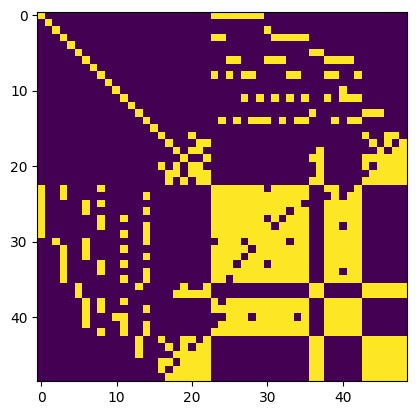

0.0


LinAlgError: Singular matrix

In [28]:
# Genrate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    np.savetxt('matrix.txt', matrix, fmt='%d')
    plt.imshow(matrix)
    plt.show()
    # Compute the inverse connectivity matrix
    print(np.linalg.det(matrix))
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix


# Choose desired settings
REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()
clique_complex = clique_complex_list[1]
print(len(clique_complex))

clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({3, 2})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({4, 1, 6})]]
#clique_complex = clique_complex_list[2]
inverse_matrix = generate_inverse_connectivity_matrix(clique_complex)[1]

In [256]:
# Choose desired settings
REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()

df_KnillF = obtain_Knill_free_energy(ID_list, clique_complex_list)
print(df_KnillF)

LinAlgError: Singular matrix